# Regression

This example will guide through a very noisy regression problem. First we have to create the regression data. The data will originate from
the function $x \cdot sin(x)$.

In [5]:
import pandas as pd
import numpy as np
import logging

logging.getLogger("/jpt").setLevel(0)
def f(x):
    return x * np.sin(x)

def generate_data(func, x_lower, x_upper, n):
    '''
    Generate a ``DataFrame`` of ``n`` data samples with additive noise from the function ``func``.
    '''
    X = np.atleast_2d(np.random.uniform(-20, 0.0, size=int(n / 2))).T
    X = np.vstack((np.atleast_2d(np.random.uniform(0, 10.0, size=int(n / 2))).T, X))
    X = X.astype(np.float32)
    X = np.array(list(sorted(X)))

    # Observations
    y = func(X).ravel()

    # Add some noise
    dy = 1.5 + .5 * np.random.random(y.shape)
    y += np.random.normal(0, dy)
    y = y.astype(np.float32)

    return pd.DataFrame(data={'x': X.ravel(), 'y': y})

df = generate_data(f, -20, 10, 1000)
df

,x,y
0,-19.944950,18.102259
1,-19.905794,16.782999
2,-19.874876,16.939438
3,-19.783342,12.793908
4,-19.721155,18.745640
...,...,...
995,9.941216,-4.190035
996,9.944221,-7.070674
997,9.953140,-1.843960
998,9.957382,-3.120459


Lets have a look at the data visually:

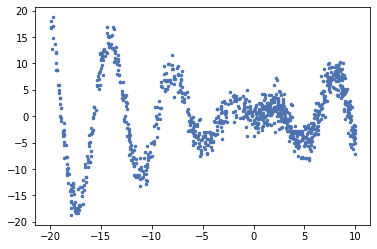

In [6]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(df['x'].values, df['y'].values, '.', markersize=5, label='Training data')
plt.show()

We can clearly see the original function, and we can observe that there is more variance towards higher x. In general, we don't want a model that assumes independent noise, and we don't want to specify much prior knowledge since it is only available rarely. Let's specify a JPT that focuses on predicting y accurately.

In [7]:
from jpt.variables import NumericVariable, VariableMap
from jpt.trees import JPT

# Construct the variables, soften up x via blur
varx = NumericVariable('x', blur=.05)
vary = NumericVariable('y')

# enable a focus on the parameters for y with the targets keyword
jpt = JPT(variables=[varx, vary], targets=[vary], min_samples_leaf=.01, min_impurity_improvement=0.01)

jpt.learn(data=df)

JPT
<DecisionNode #0 x = [x < -15.944; -15.944 ≤ x]; parent-#: None; #children: 2>
    <DecisionNode #1 x = [x < -18.815; -18.815 ≤ x]; parent-#: 0; #children: 2>
        <DecisionNode #3 x = [x < -19.231; -19.231 ≤ x]; parent-#: 1; #children: 2>
            <Leaf #7; parent: <DecisionNode #3>>
            <Leaf #8; parent: <DecisionNode #3>>
        <DecisionNode #4 x = [x < -18.336; -18.336 ≤ x]; parent-#: 1; #children: 2>
            <Leaf #9; parent: <DecisionNode #4>>
            <DecisionNode #10 x = [x < -16.596; -16.596 ≤ x]; parent-#: 4; #children: 2>
                <DecisionNode #15 x = [x < -17.973; -17.973 ≤ x]; parent-#: 10; #children: 2>
                    <Leaf #23; parent: <DecisionNode #15>>
                    <DecisionNode #24 x = [x < -17.113; -17.113 ≤ x]; parent-#: 15; #children: 2>
                        <DecisionNode #33 x = [x < -17.637; -17.637 ≤ x]; parent-#: 24; #children: 2>
                            <Leaf #47; parent: <DecisionNode #33>>
             

Since the data is 2D we can get a visual representation of the predictions of the JPT. Let's plot the predictions and get an idea of the distribution. We will plot the expectation of y for every datapoint on the x-axis and confidence intervals that explain 95% of the variance.

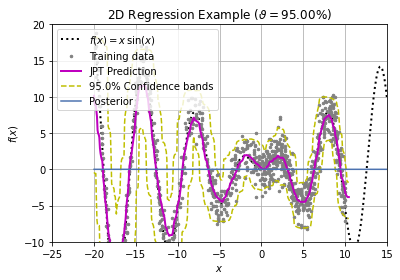

In [8]:
# Mesh the input space for evaluations of the real function,
# the prediction and its MSE
xx = np.atleast_2d(np.linspace(-20, 15, 500)).astype(np.float32).T

# Apply the JPT model
confidence = .95
conf_level = 0.95
my_predictions = [jpt.posterior([vary], evidence={varx: x_}, fail_on_unsatisfiability=False) for x_ in xx.ravel()]
y_pred_ = [(p[vary].expectation() if p is not None else None) for p in my_predictions]
y_lower_ = [(p[vary].ppf.eval((1 - conf_level) / 2) if p is not None else None) for p in my_predictions]
y_upper_ = [(p[vary].ppf.eval(1 - (1 - conf_level) / 2) if p is not None else None) for p in my_predictions]

# posterior = jpt.posterior([varx], {vary: 0})

# Plot the function, the prediction and the 90% confidence interval based on the MSE
plt.plot(xx, f(xx), color='black', linestyle=':', linewidth='2', label=r'$f(x) = x\,\sin(x)$')
plt.plot(df['x'].values, df['y'].values, '.', color='gray', markersize=5, label='Training data')
plt.plot(xx, y_pred_, 'm-', label='JPT Prediction', linewidth=2)
plt.plot(xx, y_lower_, 'y--', label='%.1f%% Confidence bands' % (confidence * 100))
plt.plot(xx, y_upper_, 'y--')
# plt.plot(xx, np.asarray(posterior.distributions[varx].pdf.multi_eval(xx.ravel().astype(np.float64))),
#          label='Posterior')
plt.plot(xx, np.array([jpt.pdf(VariableMap([(varx, x_), (vary, 0)])) for x_ in xx.ravel().astype(np.float64)]),
         label='Posterior')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.xlim(-25, 15)
plt.legend(loc='upper left')
plt.title(r'2D Regression Example ($\vartheta=%.2f\%%$)' % (confidence * 100))
plt.grid()

plt.show()

As we can see the expectations and variances predicted by the JPT characterize this dataset well and the variance even adjusts to the different x values. Impressive!